In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd

In [3]:
#read te data
training_csv_data_ori = pd.read_csv('/content/drive/MyDrive/TrainingData.csv', float_precision = 'round_trip')
val_csv_data_ori = pd.read_csv('/content/drive/MyDrive/ValidationData.csv', float_precision = 'round_trip')

In [4]:
# 根據FLOOR、BUILDING == 1篩選
training_csv_data = training_csv_data_ori[training_csv_data_ori["BUILDINGID"] == 1]
training_csv_data = training_csv_data[training_csv_data["FLOOR"] == 1]

val_csv_data = val_csv_data_ori[val_csv_data_ori["BUILDINGID"] == 1]
val_csv_data = val_csv_data[val_csv_data["FLOOR"] == 1]

In [5]:
# 刪除不必要行
training_csv_data = training_csv_data.drop(training_csv_data.keys()[522:529], axis=1)
val_csv_data = val_csv_data.drop(val_csv_data.keys()[522:529], axis=1)

In [6]:
# 100 -> -104 
training_csv_data[training_csv_data.keys()[0:520]] = training_csv_data[training_csv_data.keys()[0:520]].replace(100, -104)
val_csv_data[val_csv_data.keys()[0:520]] = val_csv_data[val_csv_data.keys()[0:520]].replace(100, -104)

In [7]:
training_csv_data = training_csv_data.reset_index(drop=True)
val_csv_data = val_csv_data.reset_index(drop=True)

In [8]:
# float -> int
"""tuple_training_csv_data、tuple_val_csv_data中只有訊號強度資訊，無座標資訊"""
tuple_training_csv_data = []
for i in range(len(training_csv_data)):
  s = pd.Series(training_csv_data.loc[i][0:520].tolist())
  tuple_training_csv_data.append(tuple(pd.to_numeric(s, downcast='integer').tolist()))

tuple_val_csv_data = []
for i in range(len(val_csv_data)):
  s = pd.Series(val_csv_data.loc[i][0:520].tolist())
  tuple_val_csv_data.append(tuple(pd.to_numeric(s, downcast='integer').tolist()))

In [9]:
# 計算一筆資料與training data中每一筆資料的歐機裡德距離(回傳陣列長度:1484)
from scipy.spatial import distance
def Euclidean_distance(input_data_tupleCoor):
  dis_arr = []
  for i in range(len(tuple_training_csv_data)):
    dis_arr.append(distance.euclidean(input_data_tupleCoor, tuple_training_csv_data[i]))
  return dis_arr

In [10]:
# 找K個最近點(KNN)，回傳k個經緯度的平均座標
# *註 : tuple_arr是一筆資料
import heapq
def KNN(tuple_arr, k):
  # 計算與training data中每筆資料的fingerprint距離
  dis_arr = Euclidean_distance(tuple_arr)

  # 篩選出最近的k個座標的index(training data中的第幾筆資料)
  dis_LO = 0.0
  dis_LA = 0.0
  min_num_index_list = list(map(dis_arr.index, heapq.nsmallest(k, dis_arr)))

  # 計算座標平均
  for i in min_num_index_list:
    dis_LO += training_csv_data.loc[i]['LONGITUDE']
    dis_LA += training_csv_data.loc[i]['LATITUDE']
  dis_LO = dis_LO/k
  dis_LA = dis_LA/k

  return dis_LO, dis_LA

In [11]:
# 計算validation誤差值(1NN、3NN、5NN)
test_k = [1,3,5]
dis_loss = []
for k in test_k:
  buffer = []
  for i in range(len(tuple_val_csv_data)):
    x,y = KNN(tuple_val_csv_data[i], k)
    val_LO = val_csv_data.loc[i]['LONGITUDE']
    val_LA = val_csv_data.loc[i]['LATITUDE']
    buffer.append(distance.euclidean((x,y), (val_LO, val_LA)))
  dis_loss.append(buffer)

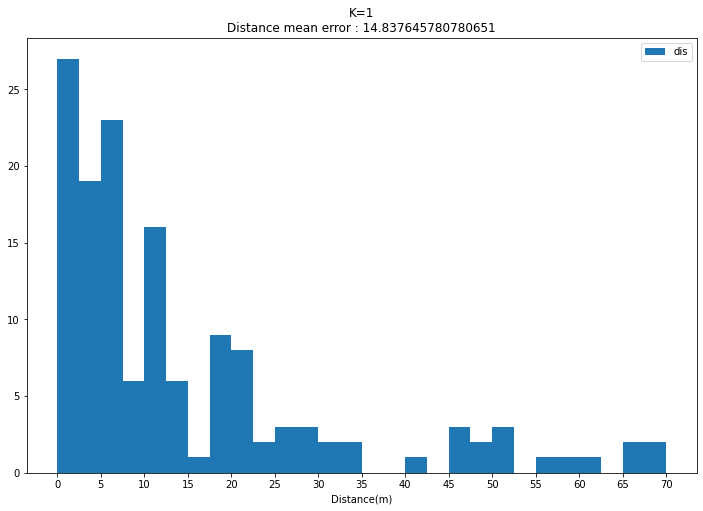

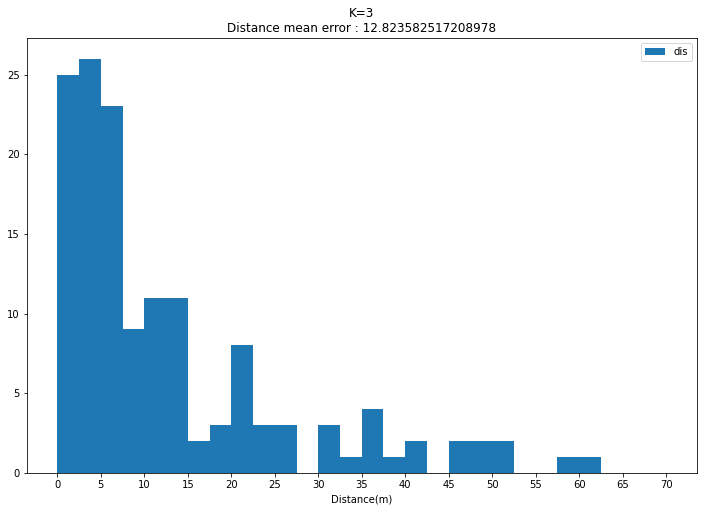

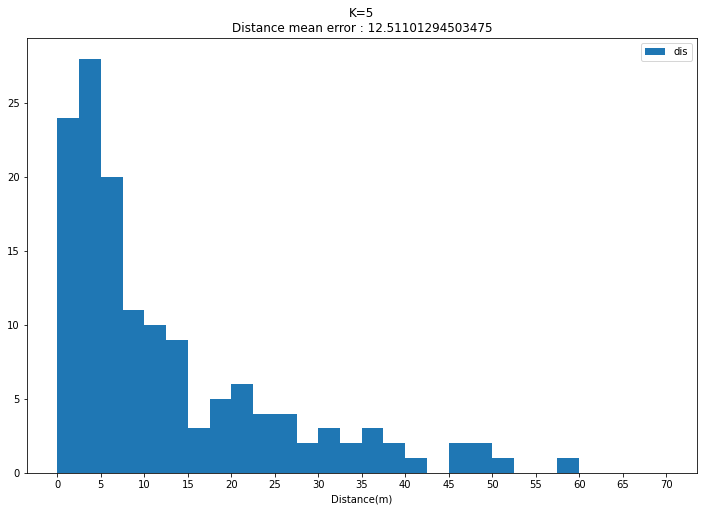

In [12]:
# 繪圖
import matplotlib.pyplot as plt
import numpy as np

""" 為了找到 bin 的數量，計算最大值和最小值之間的差除以所需的 bin寬度，以對齊線間隔。"""
def find_bins(observations, width):
    minimmum = np.min(observations)
    maximmum = np.max(observations)
    bound_min = -1.0 * (minimmum % width - minimmum)
    bound_max = maximmum - maximmum % width + width
    n = int((bound_max - bound_min) / width) + 1
    bins = np.linspace(bound_min, bound_max, n)
    return bins

for i in range(3):
  bins = find_bins(dis_loss, 2.5)
  plt.figure(figsize=(12,8))
  plt.hist(dis_loss[i], density=False, label = "dis", bins = bins)
  plt.legend()
  plt.xlabel('Distance(m)')
  plt.xticks(range(0,75,5))
  plt.figure(i+1)
  plt.plot()
  # 輸出誤差平均值
  plt.title("K="+str(test_k[i])+"\nDistance mean error : "+str(sum(dis_loss[i])/len(dis_loss[i])))

In [13]:
# plot資料讀取，處理
plot_csv_data_ori = pd.read_csv('/content/drive/MyDrive/plot.csv')
plot_csv_data_ori[plot_csv_data_ori.keys()[0:520]] = plot_csv_data_ori[plot_csv_data_ori.keys()[0:520]].replace(100, -104)

tuple_plot_csv_data_ori = []
for i in range(3):
  s = pd.Series(plot_csv_data_ori.loc[i][0:520].tolist())
  tuple_plot_csv_data_ori.append(tuple(pd.to_numeric(s, downcast='integer').tolist()))

In [14]:
# 預測 plot 資料經緯度(X, Y)
for i in range(3):
  x, y  = KNN(tuple_plot_csv_data_ori[i],5)
  print("plot 第"+str(i+1)+"筆資料")
  print("X : "+str(x)+", Y : "+str(y))
  print('\n')

plot 第1筆資料
X : -7461.3872, Y : 4864813.137800001


plot 第2筆資料
X : -7534.067063200001, Y : 4864850.5098


plot 第3筆資料
X : -7417.0628046, Y : 4864882.9088




In [15]:
# 恭喜完成R，記得把plot經緯度丟到網站上去換算，然後截圖google map